# **Artificial Neural Networks Project: Street View Housing Number Digit Recognition**
## Adapted by: Brent A. Thorne
<brentathorne@gmail.com>

--------------
## **Marks: 30 <font color='green'>$\checkmark$</font>**
--------------
Welcome to the project on classification using Artificial Neural Networks. We will work with the Street View Housing Numbers (SVHN) image dataset for this project.

--------------
## **Context** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

----------------
## **Objective**
----------------

To build a feed-forward neural network model that can recognize the digits in the images. 

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab Notebooks/content/'

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Activation,
                                     BatchNormalization,
                                     Flatten)
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

**Let us check the version of tensorflow and if we have been allocated a GPU.**

In [3]:
#print(tf.__version__)
import sys
from tensorflow.python.client import device_lib

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")

if len(tf.config.list_physical_devices('GPU')) > 0: 
  print("GPU is", "available")
else:
  print("GPU is", "NOT AVAILABLE")
  print("Note: Colab by default only allocates one GPU for all sessions.")
  print("Be sure to close any other open sessions, then restart this kernel!")
  assert(False), 'No GPU AVAILABLE. ;-('
print()
print('System Info:')
print(device_lib.list_local_devices())

Tensor Flow Version: 2.11.0
Keras Version: 2.11.0
Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Pandas 1.4.4
GPU is available

System Info:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1634657587768345592
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14385217536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8885122855043917833
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.
- Per our model description do a <font color='blue'>validation</font> split$^*$ of 0.2 on the training data.

$ ^*$Note: We are careful to do the split before normalization to avoid data leakage.

In [4]:
import h5py

# Open the file as read only
# User can make changes in the path as required
h5f = h5py.File(f'{path}/SVHN_single_grey1.h5', 'r')

# Load the training and the test dataset
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

In [5]:
# Splitting the dataset into the Training and Validation set.
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train,
    test_size = 0.2, random_state = 42, stratify = y_train)

Let's check the number of images in the training, <font color='blue'>validation</font>  and testing dataset.

In [6]:
len(X_train), len(X_validation), len(X_test)

(33600, 8400, 18000)

**Observation:**
 - There were 42,000 images in the training data.
 - after a 20% validation split we now have 33,600 images in the train set and 8,400 in the validation set.
 - This validation split will help us to train our model and adjust our model (and/or hyperparameters) without data leakage.
 - Our final model will be tested on the test dataset of 18,000 images.

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.



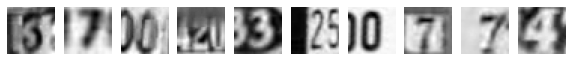

label for each of the above image: [3 7 0 2 3 2 0 7 7 4]


In [7]:
# Visualizing the first 10 images in the dataset and printing their labels
plt.figure(figsize = (10, 1))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap = "gray")
    plt.axis('off')
plt.show()

print('label for each of the above image: %s' % (y_train[0:10]))

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to <font color='red'>ANNs</font>.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [8]:
# Shape and the array of pixels for the first image
print("Shape:", X_train[0].shape)

print()
print("First image:\n", X_train[0])

Shape: (32, 32)

First image:
 [[ 96.827   91.0017  88.703  ...  52.8961  51.4833  48.6577]
 [ 85.3012  79.0029  77.0031 ...  45.054   44.5271  42.5874]
 [ 75.3022  70.3027  68.6018 ...  38.4999  36.8591  36.1042]
 ...
 [ 50.012   45.8984  43.8986 ... 107.7873 100.1301  95.0597]
 [ 50.5497  45.1373  41.7247 ... 114.1395 114.6556 110.3571]
 [ 52.0765  44.8492  39.8497 ... 118.8401 122.3667 122.0678]]


In [9]:
# Reshaping the dataset to flatten them. We are reshaping the 2D image into 1D array
X_train = X_train.reshape(X_train.shape[0], 1024)
X_validation = X_validation.reshape(X_validation.shape[0], 1024)
X_test = X_test.reshape(X_test.shape[0], 1024)

### **Question 1: Normalize the train, <font color='blue'>validation</font>, and test data. (2 Marks)**
<font color='green'>$\checkmark$</font> 

In [10]:
# Normalize inputs from 0-255 to 0-1
X_train = X_train/255.0
X_validation = X_validation/255.0
X_test = X_test/255.0

In [11]:
# New shape 
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_validation.shape, y_validation.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (33600, 1024) (33600,)
Validation set: (8400, 1024) (8400,)
Test set: (18000, 1024) (18000,)


In [12]:
# One-hot encode output
y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)
y_test = to_categorical(y_test)

# Test labels
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**Observation:**
- Notice that each entry of the target variable is a one-hot encoded vector instead of a single label.

## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

In [13]:
# Fixing the seed for random number generators
np.random.seed(42)
import random

random.seed(42)
tf.random.set_seed(42)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable. 
- Print the summary of the model.
- Fit on the train data with a <font color='blue'>**validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**</font>$^*$.
- Store the model building history to use later for visualization.

$^*$Note: We've previously split our traing and validation sets in 'Load the dataset' section above.

### **Question 2: Build and train an ANN model as per the above mentioned architecture. (10 Marks)**
<font color='green'>$\checkmark$</font> 

In [14]:
def nn_model_1():
  # Define the model
  model = Sequential() 

  # First Layer  (Input)
  # 64 nodes and relu activation with input shape = (1024, )
  model.add(Dense(64, input_shape=(1024,), activation='relu'))

  # Second Layer (Hidden)
  # 32 nodes and the relu activation
  model.add(Dense(32, activation='relu'))

  # Third Layer  (Output)
  # activation as 'softmax' with 10 nodes 
  model.add(Dense(10, activation='softmax')) # Our classifier
    
  # Compile the model
  #  loss equal to categorical_crossentropy, 
  #  optimizer equal to Adam(learning_rate = 0.001), and 
  #  metric equal to 'accuracy'
  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [15]:
# Build the model
model_1 = nn_model_1()

In [16]:
# Print the summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 68,010
Trainable params: 68,010
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit the model to training data
#  validation split of 0.2,
#  batch size = 128,
#  verbose = 1, and 
#  epochs = 20.
history_model_1 = model_1.fit(X_train, y_train,
                              validation_data=(X_validation, y_validation),
                              batch_size = 128,
                              verbose = 1,
                              epochs=20)

Epoch 1/20
263/263 [==============================] - 7s 5ms/step - loss: 2.2982 - accuracy: 0.1188 - val_loss: 2.2511 - val_accuracy: 0.1598
Epoch 2/20
263/263 [==============================] - 1s 4ms/step - loss: 2.1035 - accuracy: 0.2158 - val_loss: 1.9153 - val_accuracy: 0.3235
Epoch 3/20
263/263 [==============================] - 1s 4ms/step - loss: 1.7962 - accuracy: 0.3781 - val_loss: 1.6535 - val_accuracy: 0.4440
Epoch 4/20
263/263 [==============================] - 1s 4ms/step - loss: 1.5837 - accuracy: 0.4707 - val_loss: 1.4806 - val_accuracy: 0.5115
Epoch 5/20
263/263 [==============================] - 1s 4ms/step - loss: 1.4444 - accuracy: 0.5311 - val_loss: 1.4405 - val_accuracy: 0.5296
Epoch 6/20
263/263 [==============================] - 1s 4ms/step - loss: 1.3672 - accuracy: 0.5594 - val_loss: 1.3311 - val_accuracy: 0.5710
Epoch 7/20
263/263 [==============================] - 1s 4ms/step - loss: 1.3146 - accuracy: 0.5820 - val_loss: 1.3089 - val_accuracy: 0.5763
Epoch 

### **Plotting the validation and training accuracies**

### **Question 3: Write your observations on the below plot. (2 Marks)**
<font color='green'>$\checkmark$</font> 

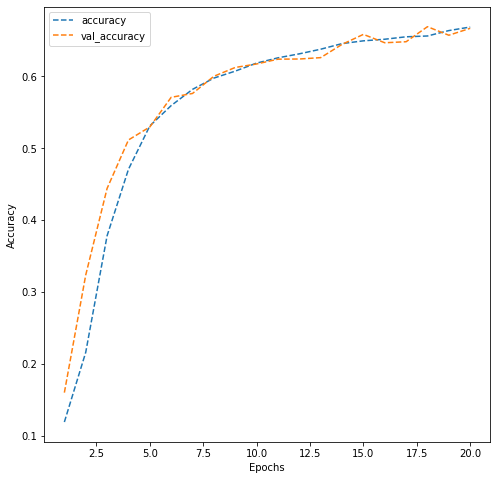

In [18]:
dict_hist = history_model_1.history
list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [19]:
# Show validation results
model_1.evaluate(X_validation, y_validation, verbose = 2)

263/263 - 0s - loss: 1.0873 - accuracy: 0.6670 - 491ms/epoch - 2ms/step


[1.0872836112976074, 0.6670238375663757]

**Observations:**

- From the plots above we see the model is generalizing well but the accuracy/val_accuracy is around 67%
- We would hope to get higher accuracy or val_accuracy scores.
- A loss of ~1.08 indicates a high number of misclassification and room for model improvement. 

Recall: categorical-cross-entropy-loss-function
 - Used for classification model where there are two or more output labels.
 - The output label is assigned one-hot category encoding value


Let's build one more model with higher complexity and see if we can improve the performance of the model. 

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [20]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [21]:
# Fixing the seed for random number generators
np.random.seed(42)

import random
random.seed(42)
tf.random.set_seed(42)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Question 4: Build and train the new ANN model as per the above mentioned architecture (10 Marks)**
<font color='green'>$\checkmark$</font> 

In [22]:
def nn_model_2():
  # Define the model
  model = Sequential() 

  # First Layer  (Input)
  # 256 nodes and the relu activation and 
  # input shape = (1024, )
  model.add(Dense(256, input_shape=(1024,), activation='relu'))

  # Second Layer (Hidden)
  # 128 nodes and the relu activation
  model.add(Dense(128, activation='relu'))

  # Dropout layer (Dropout)
  # with the rate equal to 0.2*
  model.add(Dropout(0.2))

  # Third Layer  (Hidden)
  # 64 nodes and the relu activation
  model.add(Dense(64, activation='relu'))

  # Fourth Layer  (Hidden)
  # 64 nodes and the relu activation
  model.add(Dense(64, activation='relu'))

  # Fifth Layer  (Hidden)
  # 32 nodes and the relu activation
  model.add(Dense(32, activation='relu'))

  # Batch Normalization layer (Normal)
  model.add(BatchNormalization())

  # Final Layer  (Output)
  # activation as 'softmax' with 10 nodes 
  model.add(Dense(10, activation='softmax')) # Our classifier

  # Compile the model
  #  loss equal to categorical_crossentropy, 
  #  optimizer equal to Adam(learning_rate = 0.0005), and 
  #  metric equal to 'accuracy'
  optimizer = Adam(learning_rate=0.0005)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
# Build the model
model_2 = nn_model_2()

In [24]:
# Print the summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               1

In [25]:
# Fit the model to training data
#  validation split of 0.2,
#  batch size = 128,
#  verbose = 1, and
#  epochs = 30*
history_model_2 = model_2.fit(X_train, y_train,
                              validation_data=(X_validation, y_validation),
                              batch_size = 128,
                              verbose = 1,
                              epochs=30)

Epoch 1/30
263/263 [==============================] - 6s 8ms/step - loss: 2.3211 - accuracy: 0.1112 - val_loss: 2.2652 - val_accuracy: 0.1457
Epoch 2/30
263/263 [==============================] - 1s 5ms/step - loss: 2.0499 - accuracy: 0.2250 - val_loss: 1.9549 - val_accuracy: 0.2840
Epoch 3/30
263/263 [==============================] - 1s 5ms/step - loss: 1.6825 - accuracy: 0.4081 - val_loss: 1.4860 - val_accuracy: 0.5065
Epoch 4/30
263/263 [==============================] - 1s 5ms/step - loss: 1.4140 - accuracy: 0.5328 - val_loss: 1.2610 - val_accuracy: 0.5739
Epoch 5/30
263/263 [==============================] - 1s 5ms/step - loss: 1.2704 - accuracy: 0.5885 - val_loss: 1.1866 - val_accuracy: 0.6096
Epoch 6/30
263/263 [==============================] - 2s 7ms/step - loss: 1.1749 - accuracy: 0.6217 - val_loss: 1.0733 - val_accuracy: 0.6564
Epoch 7/30
263/263 [==============================] - 2s 7ms/step - loss: 1.1149 - accuracy: 0.6432 - val_loss: 1.0450 - val_accuracy: 0.6630
Epoch 

### **Plotting the validation and training accuracies**

### **Question 5: Write your observations on the below plot. (2 Marks)**
<font color='green'>$\checkmark$</font> 

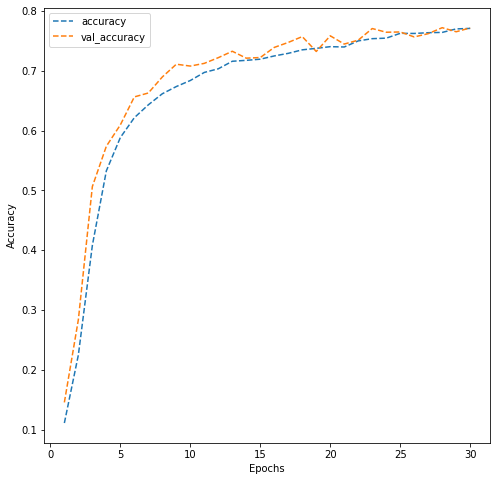

In [26]:
# Plotting the accuracies
dict_hist = history_model_2.history
list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))
plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [27]:
# Show validation results
model_2.evaluate(X_validation, y_validation, verbose = 2)

263/263 - 1s - loss: 0.7342 - accuracy: 0.7718 - 554ms/epoch - 2ms/step


[0.7341617345809937, 0.7717857360839844]

**Observations:**
- From the plots above we see an improvement with this model. 
- The validation accuracy closely fitting the training set, with a accuracy of ~78%, up from the previous 67%.
- With a loss of ~0.69 this model's classifcation ablity has greatly improved.



## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [28]:
test_pred = model_2.predict(X_test)
test_pred = np.argmax(test_pred, axis = -1)

563/563 [==============================] - 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [29]:
# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(y_test, axis = -1)

### **Question 6: Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results. (4 Marks)**
<font color='green'>$\checkmark$</font> 

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1814
           1       0.73      0.82      0.77      1828
           2       0.74      0.82      0.78      1803
           3       0.75      0.71      0.73      1719
           4       0.81      0.81      0.81      1812
           5       0.69      0.75      0.72      1768
           6       0.85      0.70      0.77      1832
           7       0.88      0.76      0.81      1808
           8       0.76      0.70      0.73      1812
           9       0.63      0.82      0.71      1804

    accuracy                           0.76     18000
   macro avg       0.77      0.76      0.76     18000
weighted avg       0.77      0.76      0.76     18000



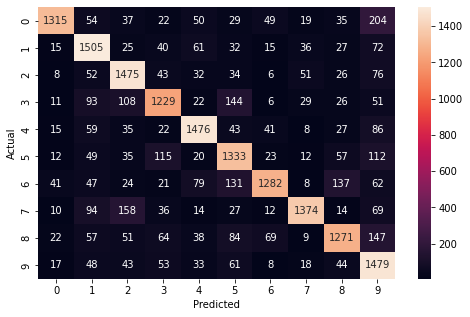

In [30]:
# Importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Printing the classification report
print(classification_report(y_test, test_pred))

# Plotting the heatmap using confusion matrix
#  Write the code for creating confusion matrix using 
#  actual labels (y_test) and predicted labels (test_pred)
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Final Observations:**
- The precision, recall and f1-score values are all around 78% which seems okay considering the image quality of the visualized samples.  

- The next step might be to analyze the misclassified images and see if we gleen some understanding into how to improve the model.
  - We can clearly see an issue between certain characters such as 5-3 and 5-8. 
  - Maybe we could weight the classifiers to improve the results.
  - We might also try to address the over-fitting by adding other dropout layer.

Note: For the sake of brevity and clarity we have omitted our further experiments with this model, which mostly resulted in over fitting.


# **Summary**

## Objective and Dataset
The objective for this project was to learn and classify address numbers from a patch of pixels.  A subset of the Street View Housing Numbers (SVHN) image dataset was used in this project.  Each image was comprised of 32-by-32 grey scales pixels. 

## Approach

An ANN model was used to recognize the digits in the images. The images were reshaping from the 2D image into 1D array for this architecure. Two Model Architectures were tested each with increasing layer complexity.   

## Key Findings

We saw an increase in epoch compute time as the complexity grew. Also as the complexity increased the total parameters increased from 68,010 to 320,627, even though dropout layers where used. The final was well fitted with precision, recall and f1-score values all above 78%.

## Conclusions and Recommendations

The next step might be to analyze the misclassified images and see if we gleen some understanding into how to improve the model. We can clearly see an issue between certain characters such as 5-3 and 5-8. Maybe we could weight the classifiers to improve the results. We might also try to address the over-fitting by adding another dropout layer.

Augmenting the training data with rotated images, area masking, random earsing, mixed image, kernel filters and noise are ways we improve model training without any changes to the architecture. We might consider implimenting this.